In [1]:
# Add submodule paths
import sys
import os
sys.path += ['./normalizing_flows', './baselines', './climdex']
# Optionally disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import utils.data as data_util
import utils.nn_util as nn
import xarray as xr
import gcsfs
import climdex.temperature as tdex
import climdex.precipitation as pdex
import logging
import tensorflow_probability as tfp
import utils.metrics as metrics
from baselines.dscnn import create_bmd_cnn10
from tensorflow.keras.models import load_model
from normalizing_flows.models import VariationalModel
from regions import southeast_us, pacific_nw
from datasource import EraiRasDataLoader
from utils.data import create_time_series_train_test_generator_v2
from utils.plot import image_map_factory, prcp_cmap
from utils.preprocessing import remove_monthly_means
from utils.distributions import normal
from tqdm import tqdm

correlation = metrics.correlation_metric()

gcs = gcsfs.GCSFileSystem(project='thesis-research-255223', token='gcs.secret.json')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
#tf.autograph.set_verbosity(1)
#tf.config.experimental_run_functions_eagerly(True)
#tf.debugging.set_log_device_placement(True)

In [3]:
data = EraiRasDataLoader(gcs_bucket='erai-rasmussen', gcs_project='thesis-research-255223', auth='gcs.secret.json')
# era-interim
erai_deg1 = xr.open_zarr(data.erai('daily-1deg'), consolidated=True).clip(min=0.0, max=np.inf)
# 1-degree regridded rasmussen
ras_deg1 = xr.open_zarr(data.rasmussen('daily-1deg'), consolidated=True).clip(min=0.0, max=np.inf)
# 1/2-degree regridded rasmussen
ras_deg12 = xr.open_zarr(data.rasmussen('daily-1-2deg'), consolidated=True).clip(min=0.0, max=np.inf)
ras_deg14 = xr.open_zarr(data.rasmussen('daily-1-4deg'), consolidated=True).clip(min=0.0, max=np.inf)
ras_deg18 = xr.open_zarr(data.rasmussen('daily-1-8deg'), consolidated=True).clip(min=0.0, max=np.inf)
ras_deg116 = xr.open_zarr(data.rasmussen('daily-1-16deg'), consolidated=True)
def get_train_test_splits(data_lo, data_hi, region_fn, scale, cv=False):
    data_lo = region_fn(data_lo)
    data_hi = region_fn(data_hi, scale_factor=scale)
    if cv:
        split_fn = create_time_series_train_test_generator_v2(n_splits=5, test_size=146)
        folds = list(split_fn(data_lo, data_hi))
        return folds
    else:
        lr_train = data_lo.isel(Time=slice(0,data_lo.Time.size-2*365))
        lr_test = data_lo.isel(Time=slice(data_lo.Time.size-2*365, data_lo.Time.size+1))
        hr_train = data_hi.isel(Time=slice(0,data_lo.Time.size-2*365))
        hr_test = data_hi.isel(Time=slice(data_lo.Time.size-2*365, data_lo.Time.size+1))
        return lr_train, lr_test, hr_train, hr_test

In [4]:
def plot_random_lr_hr_pairs(data_lr, data_hr, epsilon_prcp=1.0, i=None):
    if i is None:
        i = np.random.randint(0, data_lr.Time.size)
    maxt_lr = data_lr['MAXT'][i]
    maxt_hr = data_hr['MAXT'][i]
    prcp_lr = data_lr['PRCP'][i]
    prcp_hr = data_hr['PRCP'][i]
    fig, axs, plot_fn = image_map_factory(2, 2, figsize=(6,4))
    pmap = prcp_cmap()
    plot_fn(axs[0,0], maxt_lr, maxt_lr.lat, maxt_lr.lon, title='ERA-I, max temperature', cmap='viridis')
    cs = plot_fn(axs[0,1], maxt_hr, maxt_hr.lat, maxt_hr.lon, title='WRF-8, max temperature', cmap='viridis')
    fig.colorbar(cs, ax=axs[0].ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('max temperature (K)')
    plot_fn(axs[1,0], prcp_lr, prcp_lr.lat, prcp_lr.lon, title='ERA-I, precipitation', cmap=pmap)
    cs = plot_fn(axs[1,1], prcp_hr, prcp_hr.lat, prcp_hr.lon, title='WRF-8, precipitation', cmap=pmap)
    fig.colorbar(cs, ax=axs[1].ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('precipitation (mm)')
    return fig, i

<xarray.DataArray 'Time' ()>
array('2012-08-19T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    Time     datetime64[ns] 2012-08-19


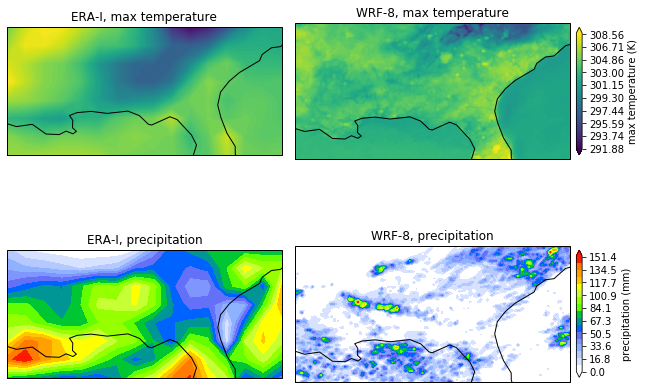

In [5]:
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(erai_deg1, ras_deg18, southeast_us, scale=8)
fig, i = plot_random_lr_hr_pairs(lr_test, hr_test, i=322)
print(hr_test.Time[i])
plt.show()

In [6]:
def metrics_file_uri(experiment_name, run_id, filename='metrics.npz'):
    return f'generative-downscaling-artifact-store/{experiment_name}/{run_id}/artifacts/data/{filename}'

def compute_metrics_maxt(hr_test, metrics):
    indices = tdex.indices('Time', convert_units_fn=lambda x: x+273.15)
    txx_pred = np.array(metrics['txx'])
    txn_pred = np.array(metrics['txn'])
    txid_pred = np.array(metrics['txid'])
    txsd_pred = np.array(metrics['txsd'])
    maxt_hr_test = hr_test
    txx_true = indices.monthly_txx(maxt_hr_test)
    txn_true = indices.monthly_txn(maxt_hr_test)
    txid_true = indices.annual_icing_days(maxt_hr_test)
    txsd_true = indices.annual_summer_days(maxt_hr_test)
    txx_corr = correlation(txx_true.values, txx_pred).numpy()
    txn_corr = correlation(txn_true.values, txn_pred).numpy()
    txsd_bias = txsd_pred - txsd_true.values
    txid_bias = txid_pred - txid_true.values
    return txx_corr, txn_corr, txsd_bias, txid_bias

def compute_metrics_prcp(hr_test, metrics):
    indices = pdex.indices('Time')
    ar20_pred = metrics['ar20'].astype(np.float64)
    prcptot_pred = metrics['atot'].astype(np.float64)
    cdd_pred = metrics['cdd'].astype(np.float64)
    cwd_pred = metrics['cwd'].astype(np.float64)
    rx1_pred = metrics['mrx1'].astype(np.float64)
    rx5_pred = metrics['mrx5'].astype(np.float64)
    prcp_hr_test = hr_test
    ar20_true = indices.annual_r20mm(prcp_hr_test).astype(np.float64)
    prcptot_true = indices.prcptot(prcp_hr_test).astype(np.float64)
    cdd_true = indices.cdd(prcp_hr_test).astype(np.float64)
    cwd_true = indices.cwd(prcp_hr_test).astype(np.float64)
    rx1_true = indices.monthly_rx1day(prcp_hr_test).astype(np.float64)
    rx5_true = indices.monthly_rx5day(prcp_hr_test).astype(np.float64)
    ar20_bias = ar20_pred - ar20_true.values
    prcptot_bias = prcptot_pred - prcptot_true.values
    cdd_corr = correlation(cdd_true.values, cdd_pred).numpy()
    cwd_corr = correlation(cwd_true.values, cwd_pred).numpy()
    rx1_corr = correlation(rx1_true.values, rx1_pred).numpy()
    rx5_corr = correlation(rx5_true.values, rx5_pred).numpy()
    return ar20_bias, prcptot_bias, cdd_corr, cwd_corr, rx1_corr, rx5_corr

### BCSD

In [7]:
# Southeast-US MAXT
folds = get_train_test_splits(erai_deg1[['MAXT']], ras_deg14[['MAXT']], southeast_us, scale=4, cv=True)
runs = ['9731548836774d7ca3e48530e6278440', '2e93ad143163439e8bfddf0913af176b', '22ddb72d7a5a424d95a775240093345d', '4e24a11413c048659eba4779ea411e36', 'bdeb2e47fffb4760ad33efa18f17f025']
metrics = np.zeros((len(runs),7))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Computing metrics for fold {i+1}/5')
    uri = metrics_file_uri('bcsd-final', run_id)
    with gcs.open(uri) as f:
        _, (lr_test, hr_test) = fold
        run_metrics = np.load(f)
        metrics[i,:3] = np.mean(run_metrics['rmse']), np.mean(run_metrics['bias']), np.mean(run_metrics['corr'])
        txx_corr, txn_corr, txsd_bias, txid_bias = compute_metrics_maxt(hr_test, run_metrics)
        metrics[i,3:] = np.mean(txx_corr), np.mean(txn_corr), np.mean(txsd_bias), np.mean(txid_bias)

Computing metrics for fold 1/5
Computing metrics for fold 2/5
Computing metrics for fold 3/5
Computing metrics for fold 4/5
Computing metrics for fold 5/5


In [8]:
metrics_df = pd.DataFrame(metrics, columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
metrics_df.mean(axis=0)

rmse         1.509054
bias        -0.015012
corr         0.926487
txx corr     0.940912
txn corr     0.937963
txsd bias   -1.120264
txid bias    0.001367
dtype: float64

In [9]:
metrics_df.std(axis=0)

rmse         0.147071
bias         0.206998
corr         0.048411
txx corr     0.047091
txn corr     0.057929
txsd bias    1.979375
txid bias    0.003442
dtype: float64

In [10]:
metrics_df

,rmse,bias,corr,txx corr,txn corr,txsd bias,txid bias
0,1.539877,-0.100678,0.943503,0.952359,0.960274,-0.029541,0.006348
1,1.532295,-0.286809,0.942312,0.981113,0.968327,-4.591797,-0.001953
2,1.412041,0.021886,0.971392,0.988001,0.991233,-0.913574,-0.000977
3,1.723785,0.008457,0.931178,0.895478,0.927142,0.077148,0.003418
4,1.337273,0.282087,0.844048,0.887607,0.842839,-0.143555,0.000000


correlation, txx: 0.8876069614251667 txn: 0.84283945368985 txsd: -0.1435546875 txid: 0.0


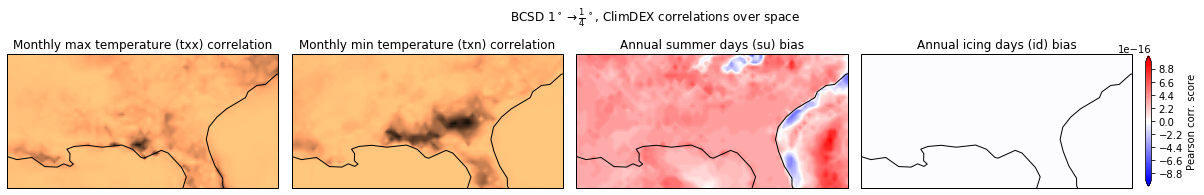

In [13]:
print(f'correlation, txx: {np.mean(txx_corr)} txn: {np.mean(txn_corr)} txsd: {np.mean(txsd_bias)} txid: {np.mean(txid_bias)}')
fig, axs, plot_fn = image_map_factory(1, 4, figsize=(6,4))
plot_fn(axs[0], txx_corr.squeeze(), hr_test.lat, hr_test.lon, title='Monthly max temperature (txx) correlation', cmap='copper')
plot_fn(axs[1], txn_corr.squeeze(), hr_test.lat, hr_test.lon, title='Monthly min temperature (txn) correlation', cmap='copper')
plot_fn(axs[2], txsd_bias.squeeze(), hr_test.lat, hr_test.lon, title='Annual summer days (su) bias', cmap='bwr')
cs = plot_fn(axs[3], txid_bias.squeeze(), hr_test.lat, hr_test.lon, title='Annual icing days (id) bias', cmap='bwr')
fig.colorbar(cs, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('Pearson corr. score')
fig.suptitle('BCSD $1^\\circ \\rightarrow \\frac{1}{4}^\\circ$, ClimDEX correlations over space', y=0.9)
plt.show()

In [14]:
# Pacific NW MAXT
folds = get_train_test_splits(erai_deg1[['MAXT']], ras_deg14[['MAXT']], pacific_nw, scale=4, cv=True)
runs = ['873f30b0b58343afb8db595f2fbe5054', 'ff633ce52a29451c8e8e8b9b41c80e12', '3b0d6ac5f3f34c39b764077e2771e431', '6b0d293560634226aadb0edfbc407f10', '5eb05cc830974ef98ba6901af7b0f0ea']
bcsd_metrics_pnw = np.zeros((len(runs),7))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Computing metrics for fold {i+1}/5')
    uri = metrics_file_uri('bcsd-final', run_id)
    with gcs.open(uri) as f:
        _, (lr_test, hr_test) = fold
        run_metrics = np.load(f)
        bcsd_metrics_pnw[i,:3] = np.mean(run_metrics['rmse']), np.mean(run_metrics['bias']), np.mean(run_metrics['corr'])
        txx_corr, txn_corr, txsd_bias, txid_bias = compute_metrics_maxt(hr_test, run_metrics)
        bcsd_metrics_pnw[i,3:] = np.mean(txx_corr), np.mean(txn_corr), np.mean(txsd_bias), np.mean(txid_bias)

Computing metrics for fold 1/5
Computing metrics for fold 2/5
Computing metrics for fold 3/5
Computing metrics for fold 4/5
Computing metrics for fold 5/5


In [15]:
bcsd_metrics_pnw_df = pd.DataFrame(bcsd_metrics_pnw, columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
bcsd_metrics_pnw_df.mean(axis=0)

rmse         1.543904
bias         0.013486
corr         0.953857
txx corr     0.972053
txn corr     0.978821
txsd bias   -0.165332
txid bias    0.216162
dtype: float64

In [16]:
bcsd_metrics_pnw_df.std(axis=0)

rmse         0.231345
bias         0.102822
corr         0.025397
txx corr     0.016032
txn corr     0.011219
txsd bias    0.347381
txid bias    0.618115
dtype: float64

In [17]:
# Southeast US PRCP
folds = get_train_test_splits(erai_deg1[['PRCP']], ras_deg14[['PRCP']], southeast_us, scale=4, cv=True)
runs = ['ab9c980eec3440aeb39caf1a66912e5f', '1dbad4ef074d441aab166b2cca8d49be', '2354e38b0a5c440e8b7dc062cf7cd06b', '2a30c9adb9d74ebcb9a67daf2c07563e', '175579b21f9240428cd16e1337c21216']
bcsd_prcp_seus = np.zeros((len(runs),9))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Computing metrics for fold {i+1}/5')
    uri = metrics_file_uri('bcsd-final', run_id)
    with gcs.open(uri) as f:
        _, (lr_test, hr_test) = fold
        run_metrics = np.load(f)
        bcsd_prcp_seus[i,:3] = np.mean(run_metrics['rmse']), np.mean(run_metrics['bias']), np.mean(run_metrics['corr'])
        ar20_bias, prcptot_bias, cdd_corr, cwd_corr, rx1_corr, rx5_corr = compute_metrics_prcp(hr_test, run_metrics)
        bcsd_prcp_seus[i,3:] = np.mean(ar20_bias), np.mean(prcptot_bias), np.mean(cdd_corr), np.mean(cwd_corr), np.mean(rx1_corr), np.mean(rx5_corr)

Computing metrics for fold 1/5
Computing metrics for fold 2/5
Computing metrics for fold 3/5
Computing metrics for fold 4/5
Computing metrics for fold 5/5


In [18]:
bcsd_prcp_seus_df = pd.DataFrame(bcsd_prcp_seus, columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr'])
bcsd_prcp_seus_df.mean(axis=0)

rmse            27.319822
bias             0.947283
corr             0.388196
ar20 bias       -0.541992
prcptot bias    44.573774
cdd corr         0.653668
cwd corr         0.488913
rx1 corr         0.407282
rx5 corr         0.518135
dtype: float64

In [19]:
bcsd_prcp_seus_df.std(axis=0)

rmse             4.973055
bias             1.382197
corr             0.070692
ar20 bias        0.849858
prcptot bias    74.128259
cdd corr         0.141170
cwd corr         0.080853
rx1 corr         0.113123
rx5 corr         0.091902
dtype: float64

In [20]:
# Pacific NW PRCP
folds = get_train_test_splits(erai_deg1[['PRCP']], ras_deg14[['PRCP']], pacific_nw, scale=4, cv=True)
runs = ['3d81e351e5104a33b7930606a12c8928', 'a4bc490dc8b4477293340805652ae44e', 'd21eba884c0241cb9263cad0204ac049', '58fa37b3989c44acb80f39a9e8fb93c6', 'd6f1815a23484f9f876f53fe95f72879']
bcsd_prcp_pnw = np.zeros((len(runs),9))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Computing metrics for fold {i+1}/5')
    uri = metrics_file_uri('bcsd-final', run_id)
    with gcs.open(uri) as f:
        _, (lr_test, hr_test) = fold
        run_metrics = np.load(f)
        bcsd_prcp_pnw[i,:3] = np.mean(run_metrics['rmse']), np.mean(run_metrics['bias']), np.mean(run_metrics['corr'])
        ar20_bias, prcptot_bias, cdd_corr, cwd_corr, rx1_corr, rx5_corr = compute_metrics_prcp(hr_test, run_metrics)
        bcsd_prcp_pnw[i,3:] = np.mean(ar20_bias), np.mean(prcptot_bias), np.mean(cdd_corr), np.mean(cwd_corr), np.mean(rx1_corr), np.mean(rx5_corr)

Computing metrics for fold 1/5
Computing metrics for fold 2/5
Computing metrics for fold 3/5
Computing metrics for fold 4/5
Computing metrics for fold 5/5


In [21]:
bcsd_prcp_pnw_df = pd.DataFrame(bcsd_prcp_pnw, columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr'])
bcsd_prcp_pnw_df.mean(axis=0)

rmse             8.898470
bias             0.411170
corr             0.609813
ar20 bias        0.570752
prcptot bias    12.920131
cdd corr         0.824486
cwd corr         0.715669
rx1 corr         0.641421
rx5 corr         0.745928
dtype: float64

In [22]:
bcsd_prcp_pnw_df.std(axis=0)

rmse             2.301896
bias             0.262754
corr             0.060343
ar20 bias        0.627211
prcptot bias    19.125394
cdd corr         0.064051
cwd corr         0.116306
rx1 corr         0.105216
rx5 corr         0.074289
dtype: float64

In [ ]:
print(f'correlation, ar20: {np.mean(ar20_corr)} prcptot: {np.mean(prcptot_corr)} cdd: {np.mean(cdd_corr)} cwd: {np.mean(cwd_corr)}, rx1: {np.mean(rx1_corr)}, rx5: {np.mean(rx5_corr)}')
fig, axs, plot_fn = image_map_factory(2, 3, figsize=(6,4))
plot_fn(axs[0,0], ar20_corr.squeeze(), hr_test.lat, hr_test.lon, title='Annual days > 20mm, corr', cmap='copper')
plot_fn(axs[0,1], prcptot_corr.squeeze(), hr_test.lat, hr_test.lon, title='Annual precip total, corr', cmap='copper')
plot_fn(axs[0,2], cdd_corr.squeeze(), hr_test.lat, hr_test.lon, title='Cumulative dry days, corr', cmap='copper')
plot_fn(axs[1,0], cwd_corr.squeeze(), hr_test.lat, hr_test.lon, title='Cumulative wet days, corr', cmap='copper')
cs = plot_fn(axs[1,1], rx1_corr.squeeze(), hr_test.lat, hr_test.lon, title='Monthly rainfall 1-day, corr', cmap='copper')
cs = plot_fn(axs[1,2], rx5_corr.squeeze(), hr_test.lat, hr_test.lon, title='Monthly rainfall 5-day, corr', cmap='copper')
fig.colorbar(cs, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('Pearson corr. score')
fig.suptitle('BCSD $1^\\circ \\rightarrow \\frac{1}{4}^\\circ$, ClimDEX correlations over space', y=0.9)
plt.show()

### Bano-Medina CNN-10

In [11]:
# from experiments.maxt_experiment_base import preprocess_fold_maxt, eval_metrics
# encoder = load_model('data/saved_models/bmd-epoch50-seus.h5')
# # workaround for loaded model not working; just pull out the weights and set them in a new model
# # encoder = create_bmd_cnn10(lr_test.lat.size, lr_test.lon.size, c_out=2, scale=4)
# # for (loaded, layer) in zip(loaded_encoder.layers, encoder.layers):
# #     layer.set_weights(loaded.get_weights())
# model = VariationalModel(encoder, normal())
# lr_train, lr_test, hr_train, hr_test = get_train_test_splits(erai_deg1[['MAXT']], ras_deg14[['MAXT']], southeast_us, scale=4)
# data = preprocess_fold_maxt(((lr_train, hr_train), (lr_test, hr_test)))
# x_test = data.test[0].to_array('chan').transpose('Time', 'lat', 'lon', 'chan').astype(np.float32)
# y_test = data.test[1].to_array('chan').transpose('Time', 'lat', 'lon', 'chan').astype(np.float32)
# y_pred = model.mean(x_test.values)
# y_true = tf.constant(y_test.values)
# indices = tdex.indices('Time', convert_units_fn=lambda x: x+273.15)
# metrics = eval_metrics(indices, y_true, y_pred, y_test.coords, data.monthly_means[1]['MAXT'])

/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/data_structures.py:669: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


In [26]:
# Southeast-US MAXT
folds = get_train_test_splits(erai_deg1[['MAXT']], ras_deg14[['MAXT']], southeast_us, scale=4, cv=True)
runs = ['6ecfe2db43894d368c181bbf782cd2f1', '30d5855d3cd544f9a0c97f006fc39cd4', '62189d38922e49f49d6a283d559fd8f3', '0556ad62281547038c3a104fa0583dab', 'c9c0accfbdb14a39aef6632265eafe03']
bmd_seus_maxt = np.zeros((len(runs),7))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Computing metrics for fold {i+1}/5')
    uri = metrics_file_uri('bmd-final', run_id, filename='metrics-epoch50.npz')
    with gcs.open(uri) as f:
        _, (lr_test, hr_test) = fold
        run_metrics = np.load(f)
        bmd_seus_maxt[i,:3] = np.mean(run_metrics['rmse']), np.mean(run_metrics['bias']), np.mean(run_metrics['corr'])
        txx_corr, txn_corr, txsd_bias, txid_bias = compute_metrics_maxt(hr_test, run_metrics)
        bmd_seus_maxt[i,3:] = np.mean(txx_corr), np.mean(txn_corr), np.mean(txsd_bias), np.mean(txid_bias)

Computing metrics for fold 1/5
Computing metrics for fold 2/5
Computing metrics for fold 3/5
Computing metrics for fold 4/5
Computing metrics for fold 5/5


In [27]:
bmd_seus_maxt_df = pd.DataFrame(bmd_seus_maxt, columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
print(bmd_seus_maxt_df.mean(axis=0))
print(bmd_seus_maxt_df.std(axis=0))

rmse         1.295184
bias         0.026604
corr         0.904313
txx corr     0.880042
txn corr     0.862912
txsd bias   -1.236035
txid bias    0.099170
dtype: float64
rmse         0.115766
bias         0.130401
corr         0.046781
txx corr     0.111750
txn corr     0.069431
txsd bias    4.483524
txid bias    0.108437
dtype: float64


In [33]:
nlls = [2.835,2.584,2.46,2.522,2.69]
print(f'{np.mean(nlls)} +/- {np.std(nlls).round(2)}')

2.6182 +/- 0.13


In [29]:
# Pacific NW MAXT
folds = get_train_test_splits(erai_deg1[['MAXT']], ras_deg14[['MAXT']], pacific_nw, scale=4, cv=True)
# TODO: rerun last fold
runs = ['8a4d85a7042a48629b13fed3c98f2221', '762187077ba648d1ab5469356d83fd78', 'ecc0eed72f474afaab553c37bcde35a4', '87924b894b854702a9b9763ebce90a5a']
bmd_pnw_maxt = np.zeros((len(runs),7))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Computing metrics for fold {i+1}/5')
    uri = metrics_file_uri('bmd-final', run_id, 'metrics-epoch50.npz')
    with gcs.open(uri) as f:
        _, (lr_test, hr_test) = fold
        run_metrics = np.load(f)
        bmd_pnw_maxt[i,:3] = np.mean(run_metrics['rmse']), np.mean(run_metrics['bias']), np.mean(run_metrics['corr'])
        txx_corr, txn_corr, txsd_bias, txid_bias = compute_metrics_maxt(hr_test, run_metrics)
        bmd_pnw_maxt[i,3:] = np.mean(txx_corr), np.mean(txn_corr), np.mean(txsd_bias), np.mean(txid_bias)

Computing metrics for fold 1/5
Computing metrics for fold 2/5
Computing metrics for fold 3/5
Computing metrics for fold 4/5


In [30]:
bmd_pnw_maxt_df = pd.DataFrame(bmd_pnw_maxt, columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
print(bmd_pnw_maxt_df.mean(axis=0))
print(bmd_pnw_maxt_df.std(axis=0))

rmse         1.293799
bias        -0.067350
corr         0.920127
txx corr     0.916686
txn corr     0.829264
txsd bias   -0.726501
txid bias    0.337463
dtype: float64
rmse         0.119424
bias         0.052941
corr         0.020032
txx corr     0.060885
txn corr     0.246594
txsd bias    0.908120
txid bias    1.120908
dtype: float64


In [34]:
nlls = [2.584,2.46,2.522,2.69]
print(f'{np.mean(nlls)} +/- {np.std(nlls).round(2)}')

2.564 +/- 0.08


In [7]:
# Southeast US PRCP
folds = get_train_test_splits(erai_deg1[['PRCP']], ras_deg14[['PRCP']], southeast_us, scale=4, cv=True)
runs = ['b22951acf857496eb4d63899479c9797', 'fb38e3d51afd43468f44aa825ba6cd42', 'c9353d690ff04480b5c3b493db62b887', 'ea8f2a388136435b80d6ba2cad2d1a79', '65344dbf0d2e47f5bfca8667df0b8819']
bmd_prcp_seus = np.zeros((len(runs),9))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Computing metrics for fold {i+1}/5')
    uri = metrics_file_uri('bmd-final', run_id, filename=f'metrics-epoch50.npz')
    with gcs.open(uri) as f:
        _, (lr_test, hr_test) = fold
        run_metrics = np.load(f)
        bmd_prcp_seus[i,:3] = np.mean(run_metrics['rmse']), np.mean(run_metrics['bias']), np.mean(run_metrics['corr'])
        ar20_bias, prcptot_bias, cdd_corr, cwd_corr, rx1_corr, rx5_corr = compute_metrics_prcp(hr_test, run_metrics)
        bmd_prcp_seus[i,3:] = np.mean(ar20_bias), np.mean(prcptot_bias), np.mean(cdd_corr), np.mean(cwd_corr), np.mean(rx1_corr), np.mean(rx5_corr)

Computing metrics for fold 1/5
Computing metrics for fold 2/5
Computing metrics for fold 3/5
Computing metrics for fold 4/5


./climdex/climdex/utils.py:66: RuntimeWarning: invalid value encountered in multiply
  chunk_indices = np.where(chunk_cond, all_indices, np.empty(chunk_cond.shape)*np.nan)


Computing metrics for fold 5/5


./climdex/climdex/utils.py:66: RuntimeWarning: invalid value encountered in multiply
  chunk_indices = np.where(chunk_cond, all_indices, np.empty(chunk_cond.shape)*np.nan)


In [9]:
bmd_prcp_seus_df = pd.DataFrame(bmd_prcp_seus, columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr'])
print(bmd_prcp_seus_df.mean(axis=0))
print(bmd_prcp_seus_df.std(axis=0))

rmse             17.172219
bias             -7.613525
corr              0.513863
ar20 bias        -6.687354
prcptot bias   -346.973226
cdd corr          0.205465
cwd corr          0.074457
rx1 corr          0.104487
rx5 corr          0.082023
dtype: float64
rmse              2.959937
bias              1.289194
corr              0.092015
ar20 bias         3.386846
prcptot bias    183.619848
cdd corr          0.217963
cwd corr          0.065394
rx1 corr          0.129941
rx5 corr          0.109508
dtype: float64


In [14]:
nlls = [1.913,1.671,1.714,1.721,1.55]
print(f'{np.mean(nlls).round(3)} +/- {np.std(nlls).round(2)}')

1.714 +/- 0.12


In [10]:
# Pacific NW PRCP
folds = get_train_test_splits(erai_deg1[['PRCP']], ras_deg14[['PRCP']], pacific_nw, scale=4, cv=True)
runs = ['b4e73032c98544e1a9b70f4c68d5eb3b', '8dc60d94af3b457eb506a70ddc0f632d', 'd6179d9b48f64b0eab2f6d0051683bff', 'feb1d3d5cc3546898a84a8f3333be4d2', 'f42546fac4e84e68890028351d0686c2']
bmd_prcp_pnw = np.zeros((len(runs),9))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Computing metrics for fold {i+1}/5')
    uri = metrics_file_uri('bmd-final', run_id, filename=f'metrics-epoch50.npz')
    with gcs.open(uri) as f:
        _, (lr_test, hr_test) = fold
        run_metrics = np.load(f)
        bmd_prcp_pnw[i,:3] = np.mean(run_metrics['rmse']), np.mean(run_metrics['bias']), np.mean(run_metrics['corr'])
        ar20_bias, prcptot_bias, cdd_corr, cwd_corr, rx1_corr, rx5_corr = compute_metrics_prcp(hr_test, run_metrics)
        bmd_prcp_pnw[i,3:] = np.mean(ar20_bias), np.mean(prcptot_bias), np.mean(cdd_corr), np.mean(cwd_corr), np.mean(rx1_corr), np.mean(rx5_corr)

Computing metrics for fold 1/5
Computing metrics for fold 2/5
Computing metrics for fold 3/5
Computing metrics for fold 4/5


./climdex/climdex/utils.py:66: RuntimeWarning: invalid value encountered in multiply
  chunk_indices = np.where(chunk_cond, all_indices, np.empty(chunk_cond.shape)*np.nan)


Computing metrics for fold 5/5


./climdex/climdex/utils.py:66: RuntimeWarning: invalid value encountered in multiply
  chunk_indices = np.where(chunk_cond, all_indices, np.empty(chunk_cond.shape)*np.nan)


In [11]:
bmd_prcp_pnw_df = pd.DataFrame(bmd_prcp_pnw, columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr'])
print(bmd_prcp_pnw_df.mean(axis=0))
print(bmd_prcp_pnw_df.std(axis=0))

rmse              6.371408
bias             -2.595036
corr              0.731898
ar20 bias        -2.143018
prcptot bias   -125.004775
cdd corr          0.110611
cwd corr          0.027982
rx1 corr          0.072506
rx5 corr          0.065327
dtype: float64
rmse             0.850160
bias             0.638896
corr             0.036983
ar20 bias        0.810353
prcptot bias    47.037797
cdd corr         0.241092
cwd corr         0.173814
rx1 corr         0.116877
rx5 corr         0.175382
dtype: float64


In [13]:
nlls = [1.524,1.46,1.395,1.569,1.518]
print(f'{np.mean(nlls).round(3)} +/- {np.std(nlls).round(2)}')

1.493 +/- 0.06


### JFLVM

In [35]:
# Southeast-US MAXT
folds = get_train_test_splits(erai_deg1[['MAXT']], ras_deg14[['MAXT']], southeast_us, scale=4, cv=True)
runs = ['da53f9e6df0a48d582b5cf5542026837', '68e50ede16a44ad19fcacd5df5bf9606', '9927867262c3450c876b453eec54e361', 'c269bf3c828140a885c521fc98512904', '9614e60894a841dd917694b2d9de9394']
jflvm_seus_maxt = np.zeros((len(runs),7))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Computing metrics for fold {i+1}/5')
    uri = metrics_file_uri('glow-jflvm-final', run_id, filename=f'metrics-fold{i}-epoch50.npz')
    with gcs.open(uri) as f:
        _, (lr_test, hr_test) = fold
        run_metrics = np.load(f)
        jflvm_seus_maxt[i,:3] = np.mean(run_metrics['rmse']), np.mean(run_metrics['bias']), np.mean(run_metrics['corr'])
        txx_corr, txn_corr, txsd_bias, txid_bias = compute_metrics_maxt(hr_test, run_metrics)
        jflvm_seus_maxt[i,3:] = np.mean(txx_corr), np.mean(txn_corr), np.mean(txsd_bias), np.mean(txid_bias)

Computing metrics for fold 1/5
Computing metrics for fold 2/5
Computing metrics for fold 3/5
Computing metrics for fold 4/5
Computing metrics for fold 5/5


In [36]:
jflvm_seus_maxt_df = pd.DataFrame(jflvm_seus_maxt, columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
print(jflvm_seus_maxt_df.mean(axis=0))
print(jflvm_seus_maxt_df.std(axis=0))

rmse         1.559211
bias        -0.004684
corr         0.868493
txx corr     0.866902
txn corr     0.839209
txsd bias   -2.268164
txid bias    0.102148
dtype: float64
rmse         0.127266
bias         0.216406
corr         0.063906
txx corr     0.127031
txn corr     0.078936
txsd bias    5.306069
txid bias    0.185138
dtype: float64


In [37]:
nlls = [0.203,0.276,0.138,0.237,0.16]
print(f'{np.mean(nlls)} +/- {np.std(nlls).round(2)}')

0.2028 +/- 0.05


In [38]:
# Pacific NW MAXT
folds = get_train_test_splits(erai_deg1[['MAXT']], ras_deg14[['MAXT']], pacific_nw, scale=4, cv=True)
runs = ['cdc0801732f94429ba20a7baecce6e19', '525a5cdb5bf045ad9cc7b07b6d6d1003', '2a2f498c04b041228921a5d6dc12d1fe', '1c83e100d57a4f67aa3d58d949f9fb5e', '07894b8a6982479cbd63f8a3faf6df71']
jflvm_pnw_maxt = np.zeros((len(runs),7))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Computing metrics for fold {i+1}/5')
    uri = metrics_file_uri('glow-jflvm-final', run_id, filename=f'metrics-fold{i}-epoch50.npz')
    with gcs.open(uri) as f:
        _, (lr_test, hr_test) = fold
        run_metrics = np.load(f)
        jflvm_pnw_maxt[i,:3] = np.mean(run_metrics['rmse']), np.mean(run_metrics['bias']), np.mean(run_metrics['corr'])
        txx_corr, txn_corr, txsd_bias, txid_bias = compute_metrics_maxt(hr_test, run_metrics)
        jflvm_pnw_maxt[i,3:] = np.mean(txx_corr), np.mean(txn_corr), np.mean(txsd_bias), np.mean(txid_bias)

Computing metrics for fold 1/5
Computing metrics for fold 2/5
Computing metrics for fold 3/5
Computing metrics for fold 4/5
Computing metrics for fold 5/5


In [39]:
jflvm_pnw_maxt_df = pd.DataFrame(jflvm_pnw_maxt, columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
print(jflvm_pnw_maxt_df.mean(axis=0))
print(jflvm_pnw_maxt_df.std(axis=0))

rmse         1.719526
bias        -0.018558
corr         0.887177
txx corr     0.826860
txn corr     0.848028
txsd bias   -1.251904
txid bias   -0.381836
dtype: float64
rmse         0.282432
bias         0.188043
corr         0.034548
txx corr     0.150108
txn corr     0.075447
txsd bias    1.200699
txid bias    1.383141
dtype: float64


In [41]:
nlls = [0.537,0.756,0.584,0.702,0.8]
print(f'{np.mean(nlls).round(3)} +/- {np.std(nlls).round(2)}')

0.676 +/- 0.1


In [7]:
# Southeast US PRCP
folds = get_train_test_splits(erai_deg1[['PRCP']], ras_deg14[['PRCP']], southeast_us, scale=4, cv=True)
runs = ['0ecf1d74228e4a16b748ce1bd3cb2f23', 'dceaad14b70142f9b12366eff26ac70b', 'df0bae41a60347438f55127269e9cec0', '39a9e4f41f52467f924c1274fc5784d7', 'd73a48b2d3544ab4aeb0d86965ce5887']
jflvm_prcp_seus = np.zeros((len(runs),9))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Computing metrics for fold {i+1}/5')
    uri = metrics_file_uri('glow-jflvm-final', run_id, filename=f'metrics-fold{i}-epoch50.npz')
    with gcs.open(uri) as f:
        _, (lr_test, hr_test) = fold
        run_metrics = np.load(f)
        jflvm_prcp_seus[i,:3] = np.mean(run_metrics['rmse']), np.mean(run_metrics['bias']), np.mean(run_metrics['corr'])
        ar20_bias, prcptot_bias, cdd_corr, cwd_corr, rx1_corr, rx5_corr = compute_metrics_prcp(hr_test, run_metrics)
        jflvm_prcp_seus[i,3:] = np.mean(ar20_bias), np.mean(prcptot_bias), np.mean(cdd_corr), np.mean(cwd_corr), np.mean(rx1_corr), np.mean(rx5_corr)

Computing metrics for fold 1/5
Computing metrics for fold 2/5
Computing metrics for fold 3/5
Computing metrics for fold 4/5
Computing metrics for fold 5/5


In [9]:
jflvm_prcp_seus_df = pd.DataFrame(jflvm_prcp_seus, columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr'])
print(jflvm_prcp_seus_df.mean(axis=0))
print(jflvm_prcp_seus_df.std(axis=0))
print(jflvm_prcp_seus_df.std(axis=0)/np.sqrt(5))

rmse            18.385473
bias             0.080231
corr             0.417637
ar20 bias        0.853613
prcptot bias    38.266188
cdd corr         0.201017
cwd corr         0.120072
rx1 corr         0.076587
rx5 corr         0.074880
dtype: float64
rmse             2.627972
bias             0.873071
corr             0.072328
ar20 bias        1.243350
prcptot bias    59.450595
cdd corr         0.253461
cwd corr         0.179897
rx1 corr         0.142635
rx5 corr         0.145998
dtype: float64
rmse             1.175265
bias             0.390449
corr             0.032346
ar20 bias        0.556043
prcptot bias    26.587114
cdd corr         0.113351
cwd corr         0.080452
rx1 corr         0.063788
rx5 corr         0.065292
dtype: float64


In [10]:
nlls = [0.916,0.539,0.726,0.764,0.499]
print(f'{np.mean(nlls).round(3)} +/- {np.std(nlls).round(2)}')

0.689 +/- 0.15


In [15]:
# Pacific NW PRCP
folds = get_train_test_splits(erai_deg1[['PRCP']], ras_deg14[['PRCP']], pacific_nw, scale=4, cv=True)
runs = ['b9e3dcfab45c476abb43d4dcf3442c99', '98cbfbbc45714fae8cde4e51ec58a414', 'b63a8c08f9a5405aaeee5bbeba9ee191', '56e6e0f0af0140d48966a1c594828628', '5daabf8566344eb893c825271b952c5a']
jflvm_prcp_pnw = np.zeros((len(runs),9))
for i, (run_id, fold) in enumerate(zip(reversed(runs), folds)):
    print(f'Computing metrics for fold {i+1}/5')
    uri = metrics_file_uri('glow-jflvm-final', run_id, filename=f'metrics-fold{i}-epoch50.npz')
    with gcs.open(uri) as f:
        _, (lr_test, hr_test) = fold
        run_metrics = np.load(f)
        jflvm_prcp_pnw[i,:3] = np.mean(run_metrics['rmse']), np.mean(run_metrics['bias']), np.mean(run_metrics['corr'])
        ar20_bias, prcptot_bias, cdd_corr, cwd_corr, rx1_corr, rx5_corr = compute_metrics_prcp(hr_test, run_metrics)
        jflvm_prcp_pnw[i,3:] = np.mean(ar20_bias), np.mean(prcptot_bias), np.mean(cdd_corr), np.mean(cwd_corr), np.mean(rx1_corr), np.mean(rx5_corr)

Computing metrics for fold 1/5
Computing metrics for fold 2/5
Computing metrics for fold 3/5


./climdex/climdex/utils.py:66: RuntimeWarning: invalid value encountered in multiply
  chunk_indices = np.where(chunk_cond, all_indices, np.empty(chunk_cond.shape)*np.nan)


Computing metrics for fold 4/5


./climdex/climdex/utils.py:66: RuntimeWarning: invalid value encountered in multiply
  chunk_indices = np.where(chunk_cond, all_indices, np.empty(chunk_cond.shape)*np.nan)


Computing metrics for fold 5/5


./climdex/climdex/utils.py:66: RuntimeWarning: invalid value encountered in multiply
  chunk_indices = np.where(chunk_cond, all_indices, np.empty(chunk_cond.shape)*np.nan)


In [16]:
jflvm_prcp_pnw_df = pd.DataFrame(jflvm_prcp_pnw, columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr'])
print(jflvm_prcp_pnw_df.mean(axis=0))
print(jflvm_prcp_pnw_df.std(axis=0))

rmse             7.337849
bias             0.542542
corr             0.668521
ar20 bias        0.468945
prcptot bias    19.560394
cdd corr         0.117609
cwd corr         0.032718
rx1 corr         0.047659
rx5 corr         0.008367
dtype: float64
rmse             0.693560
bias             0.534945
corr             0.031863
ar20 bias        0.749286
prcptot bias    34.313486
cdd corr         0.161398
cwd corr         0.232899
rx1 corr         0.148224
rx5 corr         0.214029
dtype: float64


In [13]:
nlls = [0.473,0.434,0.398,0.442,0.401]
print(f'{np.mean(nlls).round(3)} +/- {np.std(nlls).round(2)}')

0.43 +/- 0.03


### Sampling

In [ ]:
import shutil
import experiments.maxt_experiment_base as maxt
import experiments.prcp_experiment_base as prcp
from experiments.common import upsample
from models.glow import build_jflvm

def download_model(run_id, out_dir, fold=0, epoch=50):
    filenames = ['ckpt-10.index', 'ckpt-10.data-00000-of-00002', 'ckpt-10.data-00001-of-00002']
    for filename in filenames:
        with gcs.open(f'gs://generative-downscaling-artifact-store/glow-jflvm-final/{run_id}/artifacts/model/ckpt-fold{fold}-epoch{epoch}/{filename}') as src:
            with open(f'data/saved_models/glow-jflvm/{out_dir}/{filename}', 'wb') as dst:
                shutil.copyfileobj(src, dst)

erai_deg1_arr = erai_deg1[['MAXT']].to_array('chan').transpose('Time','lat','lon','chan')
ras_deg14_arr = ras_deg14[['MAXT']].to_array('chan').transpose('Time','lat','lon','chan')
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(erai_deg1_arr, ras_deg14_arr, southeast_us, scale=4)
data_fold = maxt.preprocess_fold_maxt(((lr_train, hr_train),(lr_test, hr_test)))
train_lo, train_hi = data_fold.train
test_lo, test_hi = data_fold.test
N_train, N_test = train_lo.Time.size, test_lo.Time.size
(wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
monthly_means_lo, monthly_means_hi = data_fold.monthly_means
test_ds_paired = data_fold.test_dataset(batch_size=10, buffer_size=1000,
                                        map_fn_lo=upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR),
                                        supervised=True)
model_joint = build_jflvm((None,wt_hi,ht_hi,1), scale=4, layers=3, depth=8,
                          min_filters=32, max_filters=256,
                          dnet_layers=3, dnet_filters=64)
model_joint.load('data/saved_models/glow-jflvm/maxt-seus/ckpt', 8)

In [71]:
def slerp(z1, z2, steps=4):
    assert z1.shape[0] == 1 and z2.shape[0] == 1, 'slerp only supported for one sample at a time'
    shape = z1.shape
    t = np.linspace(0.,1.,steps).reshape((steps,1))
    z1, z2 = tf.reshape(z1, (z1.shape[0],-1)), tf.reshape(z2, (z2.shape[0],-1))
    omega = tf.math.acos(tf.math.reduce_sum(z1/tf.norm(z1)*z2/tf.norm(z2)))
    sin_omega = tf.math.sin(omega)
    interpolated = tf.math.sin((1.0-t)*omega) / sin_omega * z1 + tf.math.sin(t*omega)/sin_omega * z2
    return tf.reshape(interpolated, (steps, *shape[1:]))

def sample_prediction(x, model, sigma=0.5, n=100):
    z, log_prob_x = model.encode_x(x, return_log_prob=True)
    eps = tf.random.normal((n,*z.shape[1:]), stddev=sigma)
    y, log_prob_y = model.decode_y(z+eps, return_log_prob=True)
    return y, log_prob_x, log_prob_y

In [64]:
x, y = next(test_ds_paired.__iter__())
y_pred = model_joint.predict_y(x)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [21]:
z_y, log_prob_y = model_joint.encode_y(y, return_log_prob=True)
z_yp, log_prob_yp = model_joint.encode_y(y_pred, return_log_prob=True)

In [22]:

    
zs = slerp(z_y[1:2],z_yp[1:2], steps=8)
y_interp = model_joint.decode_y(zs)

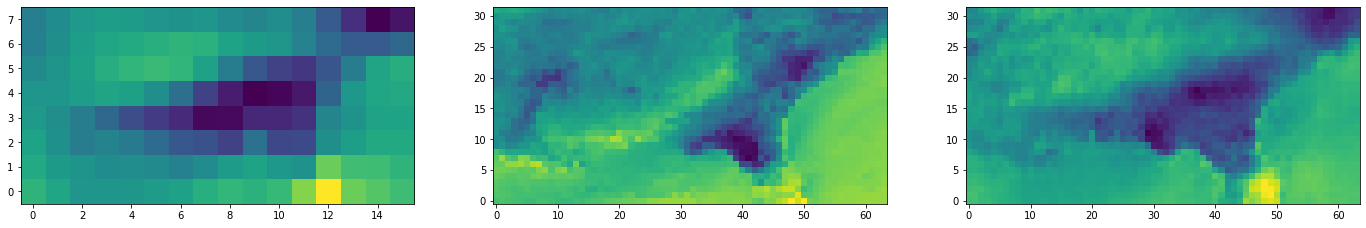

In [26]:
plt.figure(figsize=(3*8,6))
plt.subplot(1,3,1)
plt.imshow(tf.squeeze(tf.image.resize(x[1], (wt,ht), method='nearest')).numpy(), origin='lower')
plt.subplot(1,3,2)
plt.imshow(tf.squeeze(y[1]).numpy(), origin='lower')
plt.subplot(1,3,3)
plt.imshow(tf.squeeze(y_pred[1]).numpy(), origin='lower')
plt.savefig("test.eps")

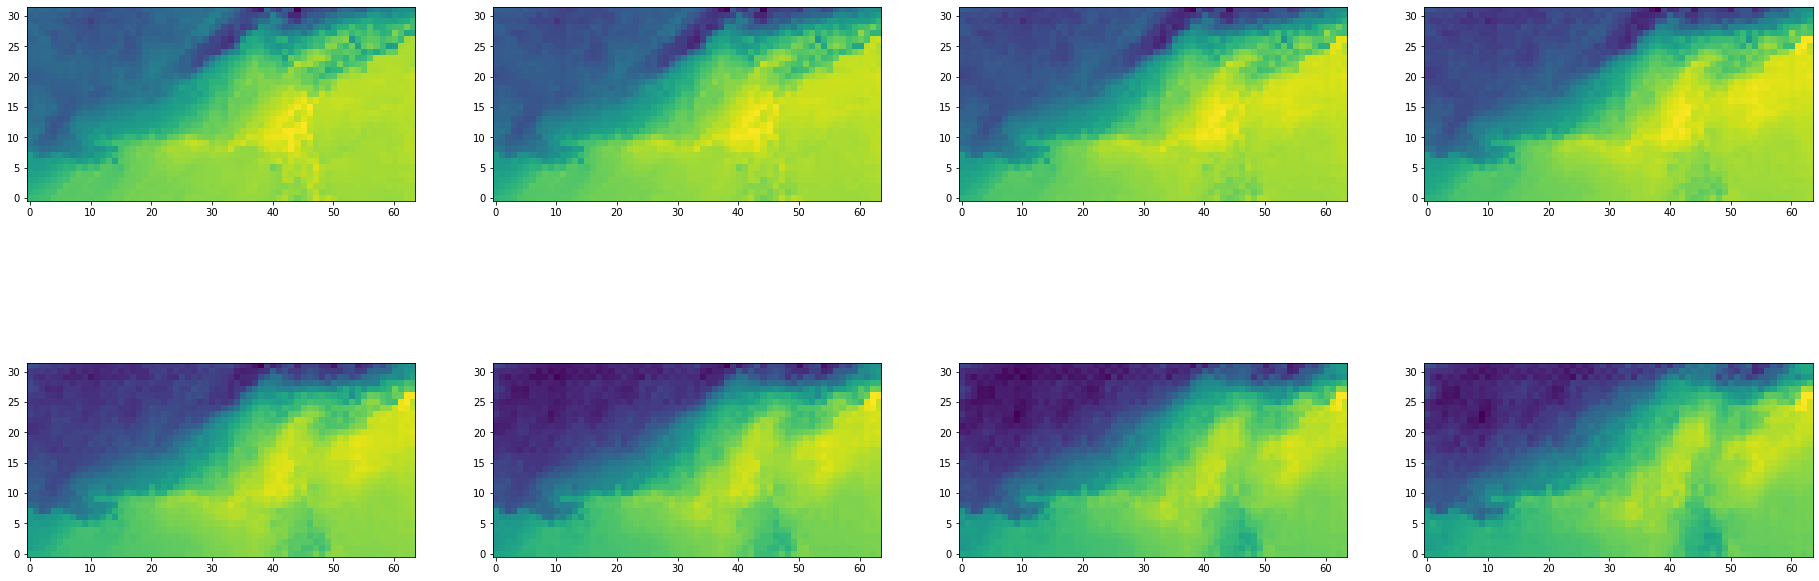

In [77]:
plt.figure(figsize=(4*8,2*6))
plt.subplot(2,4,1)
plt.imshow(tf.squeeze(y_interp[0]).numpy(), origin='lower')
plt.subplot(2,4,2)
plt.imshow(tf.squeeze(y_interp[1]).numpy(), origin='lower')
plt.subplot(2,4,3)
plt.imshow(tf.squeeze(y_interp[2]).numpy(), origin='lower')
plt.subplot(2,4,4)
plt.imshow(tf.squeeze(y_interp[3]).numpy(), origin='lower')
plt.subplot(2,4,5)
plt.imshow(tf.squeeze(y_interp[4]).numpy(), origin='lower')
plt.subplot(2,4,6)
plt.imshow(tf.squeeze(y_interp[5]).numpy(), origin='lower')
plt.subplot(2,4,7)
plt.imshow(tf.squeeze(y_interp[6]).numpy(), origin='lower')
plt.subplot(2,4,8)
plt.imshow(tf.squeeze(y_interp[7]).numpy(), origin='lower')

In [65]:
erai_deg1_arr = prcp.preprocess_dataset(erai_deg1[['PRCP']], erai_deg1['PRCP'].shape)
erai_deg1_arr = erai_deg1_arr.to_array('chan').transpose('Time','lat','lon','chan')
ras_deg14_arr = prcp.preprocess_dataset(ras_deg14[['PRCP']], ras_deg14['PRCP'].shape)
ras_deg14_arr = ras_deg14_arr.to_array('chan').transpose('Time','lat','lon','chan')
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(erai_deg1_arr, ras_deg14_arr, southeast_us, scale=4)
data_fold = prcp.preprocess_fold_prcp(((lr_train, hr_train),(lr_test, hr_test)))
train_lo, train_hi = data_fold.train
test_lo, test_hi = data_fold.test
N_train, N_test = train_lo.Time.size, test_lo.Time.size
(wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
test_ds_paired = data_fold.test_dataset(batch_size=10, buffer_size=1000,
                                        map_fn_lo=upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR),
                                        supervised=True)
model_joint = build_jflvm((None,wt_hi,ht_hi,1), scale=4, layers=3, depth=4,
                          min_filters=32, max_filters=256,
                          dnet_layers=3, dnet_filters=64)
model_joint.load('data/saved_models/glow-jflvm/prcp-seus/ckpt', 10)

In [154]:
x, y = next(test_ds_paired.__iter__())

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [155]:
y_pred = model_joint.predict_y(x[:1])
y_samples,_,_ = sample_prediction(x[:1], model_joint, sigma=0.5)
y_samples = y_samples**3
y_samples = tf.where(y_samples > 5.0, y_samples, 0.0)
x, y, y_pred = x**3, y**3, y_pred**3
x = tf.image.resize(x, (wt,ht), method='nearest')

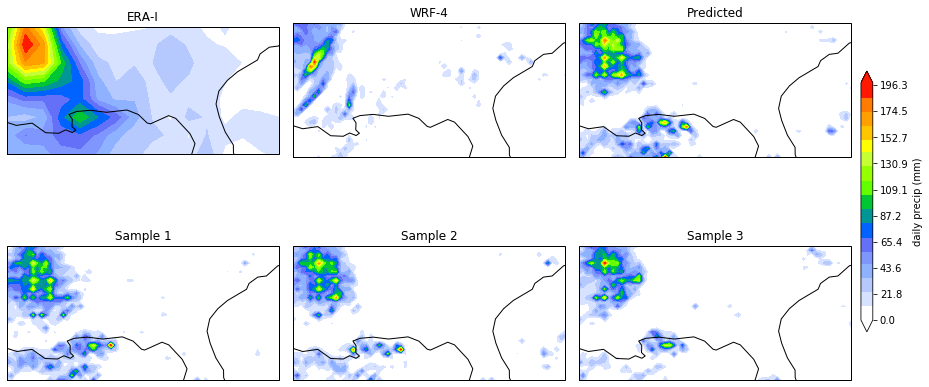

In [156]:
fig, axs, plot_fn = image_map_factory(2, 3, figsize=(6,4))
pmap = prcp_cmap()
plot_fn(axs[0,0], x[0].numpy().squeeze(), lr_test.lat, lr_test.lon, title='ERA-I', cmap=pmap)
plot_fn(axs[0,1], y[0].numpy().squeeze(), hr_test.lat, hr_test.lon, title='WRF-4', cmap=pmap)
plot_fn(axs[0,2], y_pred[0].numpy().squeeze(), hr_test.lat, hr_test.lon, title='Predicted', cmap=pmap)
plot_fn(axs[1,0], y_samples[0].numpy().squeeze(), hr_test.lat, hr_test.lon, title='Sample 1', cmap=pmap)
plot_fn(axs[1,1], y_samples[1].numpy().squeeze(), hr_test.lat, hr_test.lon, title='Sample 2', cmap=pmap)
cs = plot_fn(axs[1,2], y_samples[2].numpy().squeeze(), hr_test.lat, hr_test.lon, title='Sample 3', cmap=pmap)
fig.colorbar(cs, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('daily precip (mm)')